# 2D Decision Boundary 

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as snb 
from mpl_toolkits.axes_grid1 import make_axes_locatable
snb.set_theme()
snb.set(font_scale=2)


In [2]:
# Helper funcitons
def plot_data(Z, t, ax, digits, title=""):
    ax.plot(Z[t==0, 0], Z[t==0, 1], 'b.', label='Digit: %d' % digits[0])
    ax.plot(Z[t==1, 0], Z[t==1, 1], 'r.', label='Digit: %d' % digits[1])
    ax.legend()
    ax.set(title=title, xlabel='PC1', ylabel='PC2');

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

def eval_density_grid(density_fun, w, P=100):
    x_grid = np.linspace(-3.0, 4.5, P)
    X1, X2 = np.meshgrid(x_grid, x_grid)
    XX = np.column_stack((X1.ravel(), X2.ravel()))
    return x_grid, density_fun(XX, w).reshape((P, P))

### Data 

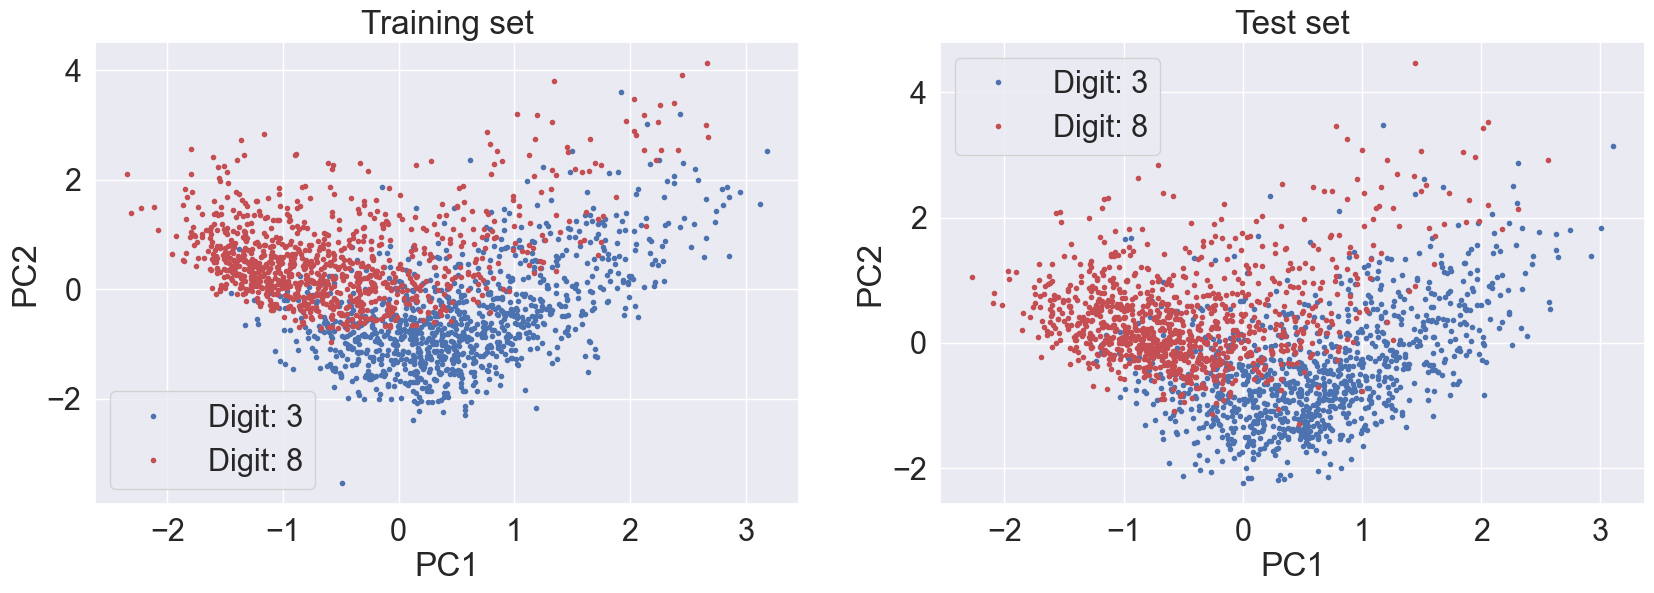

In [3]:
# pick out 3000 data points since too many data points makes it difficult to see what is going on 
points = np.arange(3000, 5000)
data = np.load("data.npy", allow_pickle=True).item()
X_train = data['X_train'][points]; X_test = data['X_train'][np.arange(9000, 11000)]; y_train = data['t_train'][points]; y_test = data['t_train'][np.arange(9000, 11000)]

# reduce dimensionality to 2D using PCA 
def prep_PCA(X, dim=2):
    # reduce dimensionality to 2D using principal component analysis (PCA)
    U, s, V = np.linalg.svd(X)

    # get eigenvectors corresponding to the two largest eigenvalues
    eigen_vecs = V[:dim, :]
    eigen_vals = s[:dim]

    # set-up projection matrix
    Pmat = eigen_vecs.T*(np.sqrt(len(X))/eigen_vals)
    
    return Pmat

# project to 2D using PCA
Pmat = prep_PCA(X_train)
Z_train = X_train @ Pmat
Z_test = X_test @ Pmat


# # plot
%matplotlib inline 
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(Z_train, y_train, ax[0], [3, 8], title='Training set')
plot_data(Z_test, y_test, ax[1], [3, 8], title='Test set')

# # for saving images 
# %matplotlib qt 
# fig, ax = plt.subplots(1, 1, figsize = (8, 8))
# plot_data(Z_test, y_test, ax, [3, 8], title = "Test Set")

### Logistic Regression 

In [4]:
from model import LogisticRegression

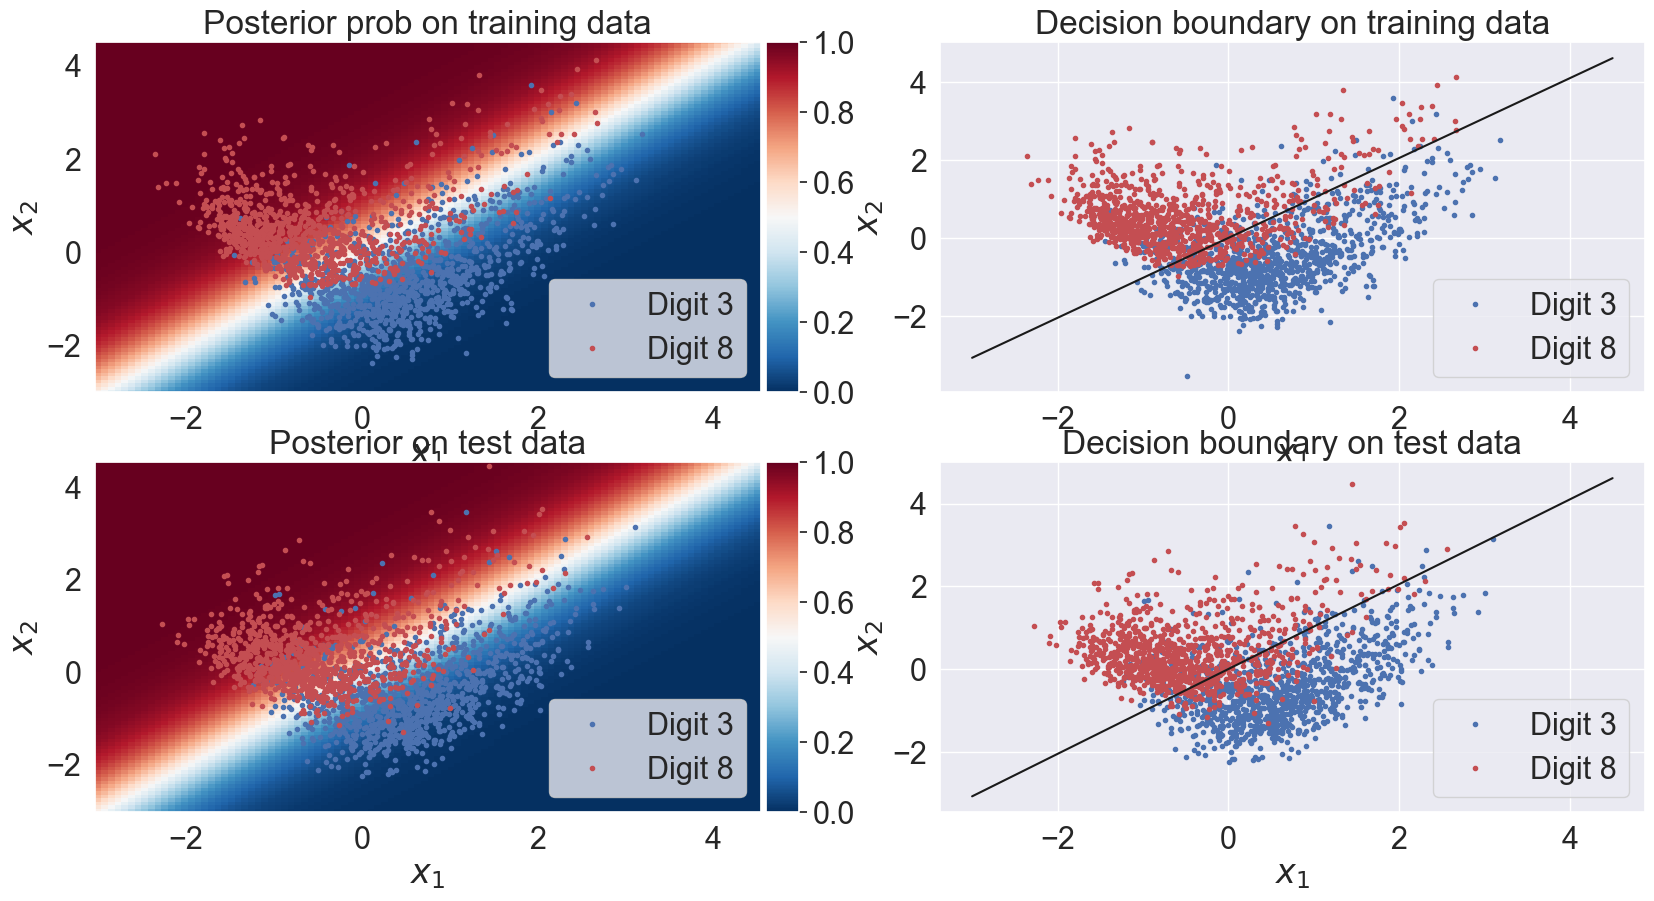

accuracy = 0.852


In [5]:
# initialize parameters 
lam = 1e-2
sigma = 0.1


# run logistic regression
regressor = LogisticRegression(learning_rate=0.001, num_iterations = 300, lam = lam, sigma = sigma)
regressor.fit(Z_train, y_train)
weights = regressor.w

accuracy_log = regressor.accuracy(Z_test, y_test)
# evaluate posterior distribution
sigmoid = lambda x: 1/(1 + np.exp(-x))
posterior1 = lambda x, w: sigmoid(w[0] + x @ w[1:])
x_grid, posterior1_eval = eval_density_grid(posterior1, weights)

# decision boundary 
decision = -(weights[0] + weights[1]*x_grid)/weights[2]

##########################################################################
#                                   plot                                 # 
##########################################################################
%matplotlib inline 
fig, ax =  plt.subplots(2, 2, figsize=(20, 10))

im = ax[0, 0].pcolormesh(x_grid, x_grid, posterior1_eval, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
ax[0, 0].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[0, 0].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
ax[0, 0].set(title='Posterior prob on training data', xlabel='$x_1$', ylabel='$x_2$')
ax[0, 0].set_ylim([-3, 4.5])
ax[0, 0].legend()
add_colorbar(im, fig, ax[0, 0])

# third plot
ax[0, 1].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[0, 1].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
ax[0, 1].plot(x_grid, decision, 'k-')
ax[0, 1].set(title='Decision boundary on training data', xlabel='$x_1$', ylabel='$x_2$')
ax[0, 1].legend()

im = ax[1 ,0].pcolormesh(x_grid, x_grid, posterior1_eval, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
ax[1, 0].plot(Z_test[y_test==0, 0], Z_test[y_test==0, 1], 'b.', label='Digit 3')
ax[1, 0].plot(Z_test[y_test==1, 0], Z_test[y_test==1, 1], 'r.', label='Digit 8')
ax[1, 0].set(title='Posterior on test data', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 0].legend()
add_colorbar(im, fig, ax[1, 0])

# third plot
ax[1, 1].plot(Z_test[y_test==0, 0], Z_test[y_test==0, 1], 'b.', label='Digit 3')
ax[1, 1].plot(Z_test[y_test==1, 0], Z_test[y_test==1, 1], 'r.', label='Digit 8')
ax[1, 1].set(title='Decision boundary on test data', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 1].plot(x_grid, decision, 'k-')
ax[1, 1].legend()

plt.show()

print(f"accuracy = {accuracy_log}")

# # # # # # To save # # # # # 
# %matplotlib qt 
# fig, ax =  plt.subplots(1, 2, figsize=(15, 6))

# im = ax[0].pcolormesh(x_grid, x_grid, posterior1_eval, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
# ax[0].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
# ax[0].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
# ax[0].set(title='Posterior prob on training data', xlabel='$x_1$', ylabel='$x_2$')
# ax[0].set_ylim([-3, 4.5])
# ax[0].legend()
# add_colorbar(im, fig, ax[0])

# # third plot
# ax[1].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
# ax[1].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
# ax[1].plot(x_grid, decision, 'k-')
# ax[1].set(title='Decision boundary on training data', xlabel='$x_1$', ylabel='$x_2$')
# ax[1].legend()

# plt.show()

### Removal 

In [6]:
from removal_algorithm import removal

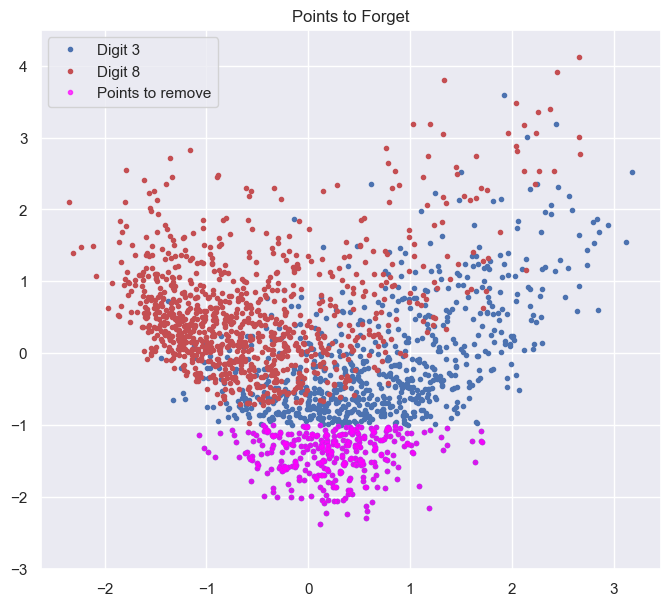

In [7]:
# illustrate the removed points 
# extreme case 
# mask = (y_train == 1) & (Z_train[:, 0] < 0 ) & (Z_train[:, 1] > -2)
# reverse_mask = (y_train == 1) & (~mask)

# soft example 
# mask = (y_train == 1) & (Z_train[:, 0] > -0.5 ) & (Z_train[:, 1] > -2) & (Z_train[:, 0] < 1) & (Z_train[:, 1] < 1)
# reverse_mask = (y_train == 1) & (~mask)

# remove bottom blue points 
mask = (y_train == 0) & (Z_train[:, 1] < -1)
reverse_mask = (y_train == 0) & (~mask)

# mask = (y_train == 1) & (Z_train[:, 0] > 0.5) 
# reverse_mask = (y_train == 1) & (~mask)
c = 0

%matplotlib inline 
# %matplotlib qt 
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
plt.plot(Z_train[y_train == 0, 0], Z_train[y_train == 0, 1], 'b.', label = "Digit 3")
plt.plot(Z_train[y_train == 1, 0], Z_train[y_train == 1, 1], 'r.', label = "Digit 8")
plt.plot(Z_train[mask, 0], Z_train[mask, 1], '.', color =[1, 0, 1], alpha = 0.7, label = "Points to remove")
plt.ylim([-3, 4.5])
plt.title("Points to Forget")
plt.legend()
plt.show()


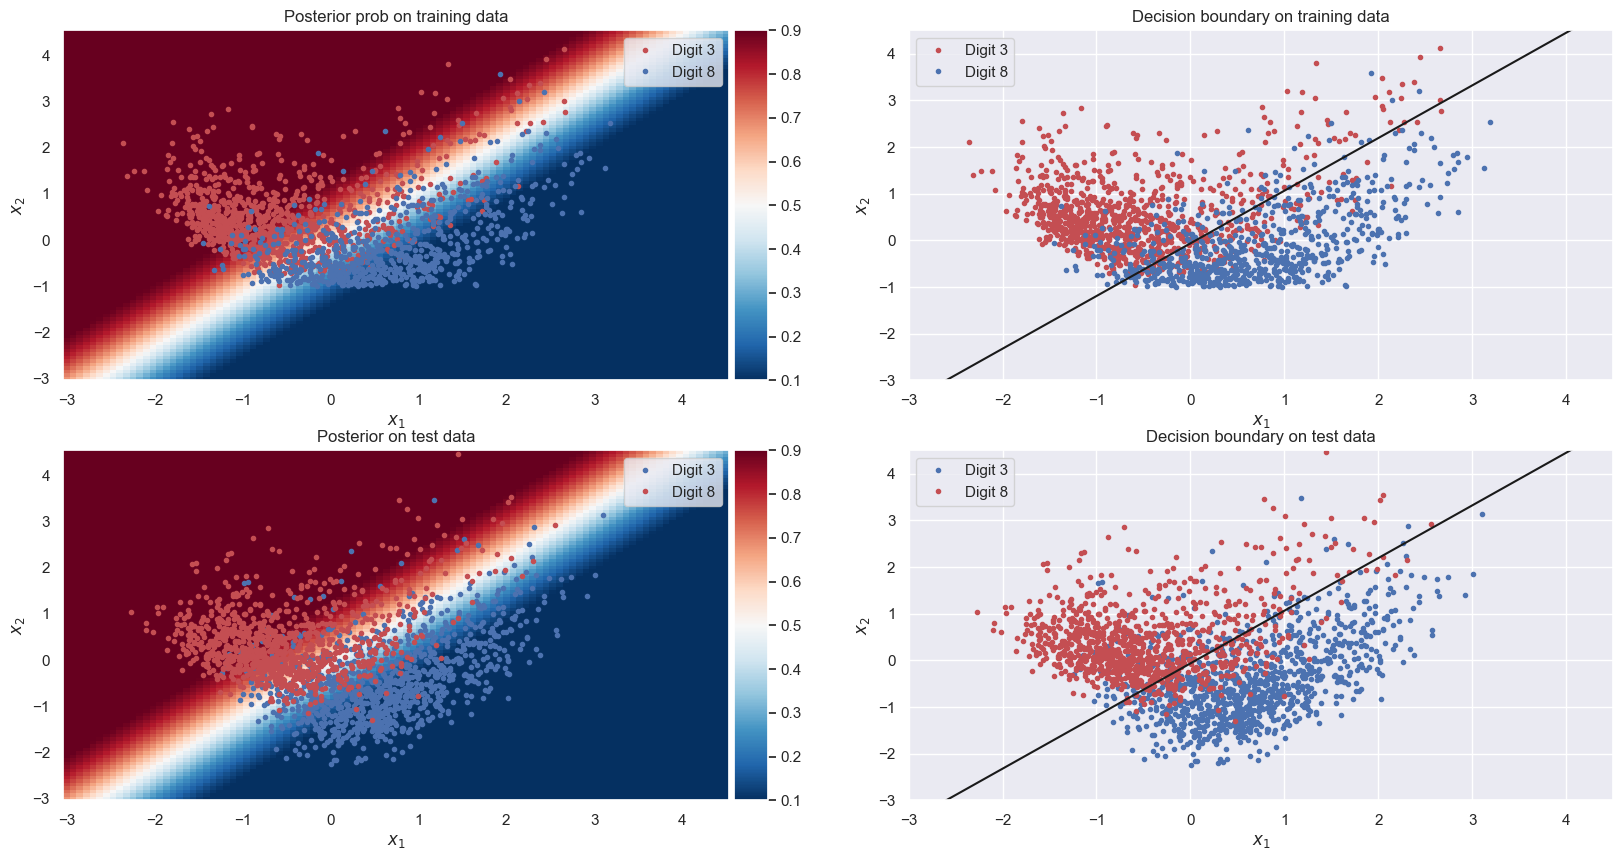

Accuracy = 0.857


In [8]:
# restructued Z_train so removed points are in the top (what removal algorithm expects)
removed_points = Z_train[mask]
removed_targets = y_train[mask]
idx = mask * np.arange(len(mask))
Z_train_remove = np.delete(Z_train, idx, axis = 0)
Z_train_remove = np.r_[removed_points, Z_train_remove]
y_train_remove = np.delete(y_train, idx)
y_train_remove = np.concatenate([removed_targets, y_train_remove])

# init parameters 
gamma = 0.25
num_remove = np.sum(mask)
eps = 1e1
delta = 1e-4 
m = 10

# run removal 
weights_updated, _ = removal(Z_train_remove, y_train_remove, eps, delta, sigma, lam, gamma, num_remove, weights, m)

x_grid, posterior1_eval_updated = eval_density_grid(posterior1, weights_updated)
decision_updated = -(weights_updated[0] + weights_updated[1]*x_grid)/weights_updated[2]

regressor.set_weights(weights_updated)
accuracy_removed = regressor.accuracy(Z_test, y_test)

##########################################################################
#                                   plot                                 # 
##########################################################################
%matplotlib inline 
fig, ax =  plt.subplots(2, 2, figsize=(20, 10))

im = ax[0, 0].pcolormesh(x_grid, x_grid, posterior1_eval_updated, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.1, vmax = 0.9)
color1 = 'r.' if c == 1 else 'b.'
color2 = 'r.' if c == 0 else 'b.'
ax[0, 0].plot(Z_train[y_train != c, 0], Z_train[y_train != c, 1], color2, label='Digit 3')
ax[0, 0].plot(Z_train[reverse_mask, 0], Z_train[reverse_mask, 1], color1, label='Digit 8')
ax[0, 0].set(title='Posterior prob on training data', xlabel='$x_1$', ylabel='$x_2$')
ax[0, 0].legend()
add_colorbar(im, fig, ax[0, 0])


# third plot
ax[0, 1].plot(Z_train[y_train != c, 0], Z_train[y_train != c, 1], color2, label='Digit 3')
ax[0, 1].plot(Z_train[reverse_mask, 0], Z_train[reverse_mask, 1], color1, label='Digit 8')
# ax[0, 1].plot(Z_train[mask, 0], Z_train[mask, 1], '.', color =[1, 0, 1], alpha = 0.7, label = "Removed points")
ax[0, 1].plot(x_grid, decision_updated, 'k-')
ax[0, 1].set(title='Decision boundary on training data', xlabel='$x_1$', ylabel='$x_2$')
ax[0, 1].set_xlim([-3.0, 4.5])
ax[0, 1].set_ylim([-3.0, 4.5])
ax[0, 1].legend()

im = ax[1 ,0].pcolormesh(x_grid, x_grid, posterior1_eval_updated, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.1, vmax = 0.9)
ax[1, 0].plot(Z_test[y_test==0, 0], Z_test[y_test==0, 1], 'b.', label='Digit 3')
ax[1, 0].plot(Z_test[y_test==1, 0], Z_test[y_test==1, 1], 'r.', label='Digit 8')
ax[1, 0].set(title='Posterior on test data', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 0].legend()
add_colorbar(im, fig, ax[1, 0])

# third plot
ax[1, 1].plot(Z_test[y_test==0, 0], Z_test[y_test==0, 1], 'b.', label='Digit 3')
ax[1, 1].plot(Z_test[y_test==1, 0], Z_test[y_test==1, 1], 'r.', label='Digit 8')
ax[1, 1].set(title='Decision boundary on test data', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 1].plot(x_grid, decision_updated, 'k-')
ax[1, 1].set_xlim([-3.0, 4.5])
ax[1, 1].set_ylim([-3.0, 4.5])
ax[1, 1].legend()

plt.show()

# # # # To save # # # # #
%matplotlib qt 
fig, ax =  plt.subplots(1, 2, figsize=(15, 7))

im = ax[0].pcolormesh(x_grid, x_grid, posterior1_eval_updated, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
color1 = 'r.' if c == 1 else 'b.'
color2 = 'r.' if c == 0 else 'b.'
ax[0].plot(Z_train[y_train != c, 0], Z_train[y_train != c, 1], color2, label='Digit 3')
ax[0].plot(Z_train[reverse_mask, 0], Z_train[reverse_mask, 1], color1, label='Digit 8')
ax[0].set(title='Posterior prob on training data', xlabel='$x_1$', ylabel='$x_2$')
ax[0].legend()
ax[0].set_xlim([-3.0, 4.5])
ax[0].set_ylim([-3.0, 4.5])
add_colorbar(im, fig, ax[0])


# third plot
ax[1].plot(Z_train[y_train != c, 0], Z_train[y_train != c, 1], color2, label='Digit 3')
ax[1].plot(Z_train[reverse_mask, 0], Z_train[reverse_mask, 1], color1, label='Digit 8')
# ax[0, 1].plot(Z_train[mask, 0], Z_train[mask, 1], '.', color =[1, 0, 1], alpha = 0.7, label = "Removed points")
ax[1].plot(x_grid, decision_updated, 'k-')
ax[1].set(title='Decision boundary on training data', xlabel='$x_1$', ylabel='$x_2$')
ax[1].set_xlim([-3.0, 4.5])
ax[1].set_ylim([-3.0, 4.5])
ax[1].legend()

plt.show()

print(f"Accuracy = {accuracy_removed}")

## Plot decision side by side 

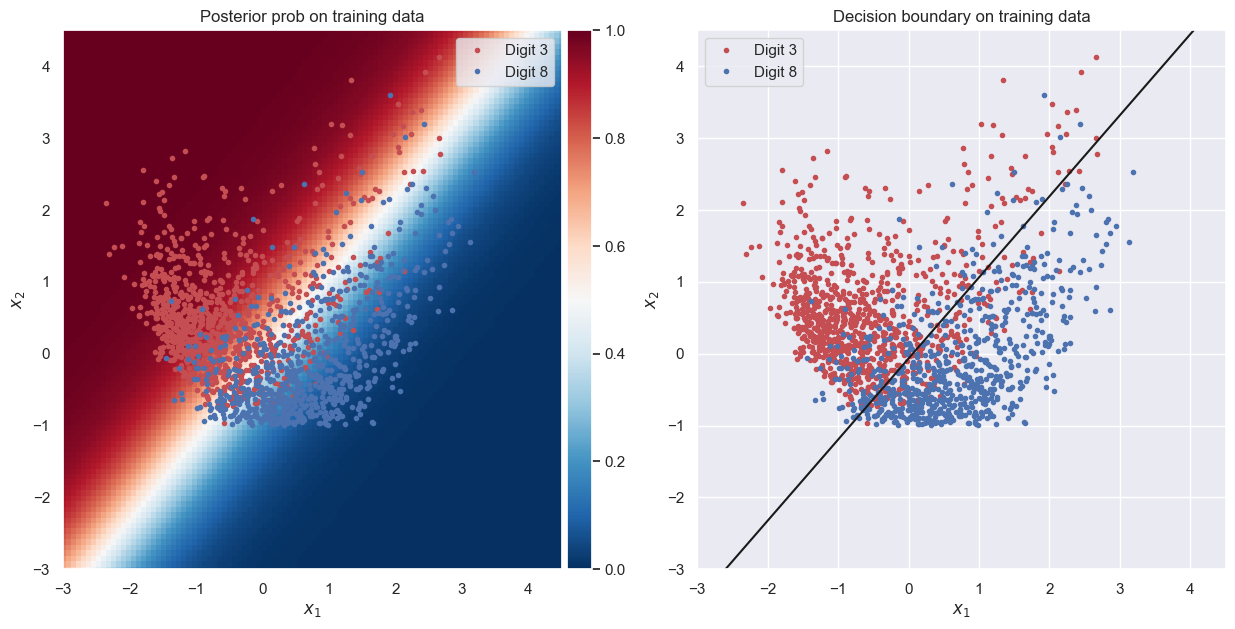

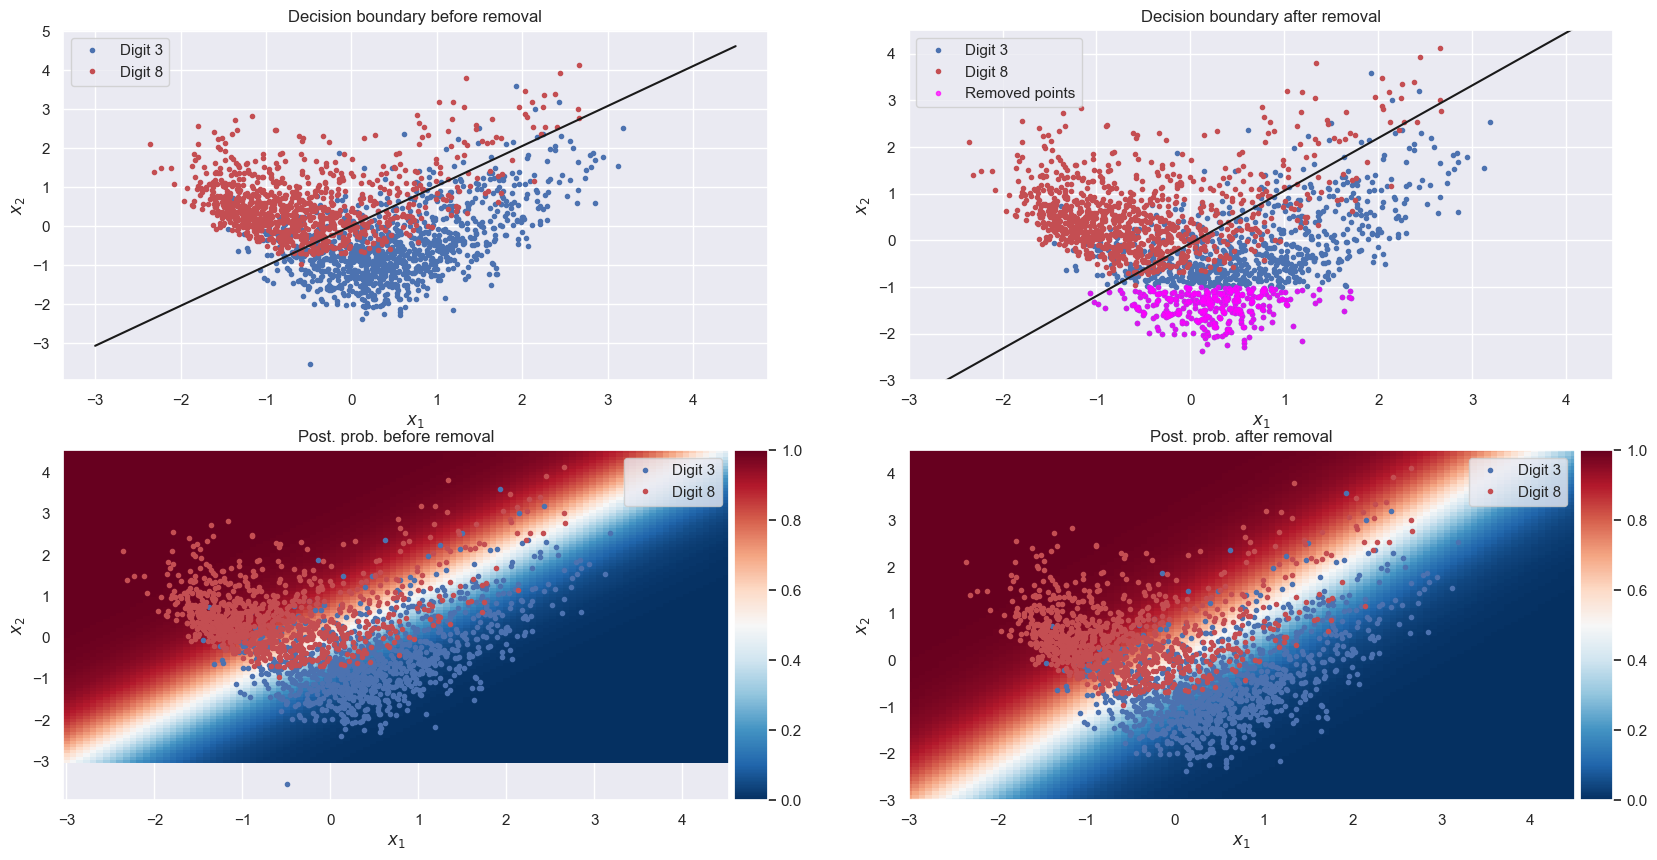

In [9]:
%matplotlib inline 
fig, ax =  plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[0, 0].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
# ax[0, 0].plot(Z_train[mask, 0], Z_train[mask, 1], '.', color =[1, 0, 1], alpha = 0.7, label = "Removed points")
ax[0, 0].plot(x_grid, decision, 'k-')
ax[0, 0].set(title='Decision boundary before removal', xlabel='$x_1$', ylabel='$x_2$')
ax[0, 0].legend()

ax[0, 1].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[0, 1].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
ax[0, 1].plot(Z_train[mask, 0], Z_train[mask, 1], '.', color =[1, 0, 1], alpha = 0.7, label = "Removed points")
ax[0, 1].set(title='Decision boundary after removal', xlabel='$x_1$', ylabel='$x_2$')
ax[0 ,1].plot(x_grid, decision_updated, 'k-')
ax[0, 1].set_xlim([-3.0, 4.5])
ax[0, 1].set_ylim([-3.0, 4.5])
ax[0, 1].legend()


im = ax[1, 0].pcolormesh(x_grid, x_grid, posterior1_eval, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
ax[1, 0].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[1, 0].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
ax[1, 0].set(title='Post. prob. before removal', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 0].legend()
add_colorbar(im, fig, ax[1, 0])

im = ax[1, 1].pcolormesh(x_grid, x_grid, posterior1_eval_updated, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
ax[1, 1].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[1, 1].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
ax[1, 1].set(title='Post. prob. after removal', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 1].set_xlim([-3.0, 4.5])
ax[1, 1].set_ylim([-3.0, 4.5])
ax[1, 1].legend()
add_colorbar(im, fig, ax[1, 1])


plt.show()

### compare to retrained model 

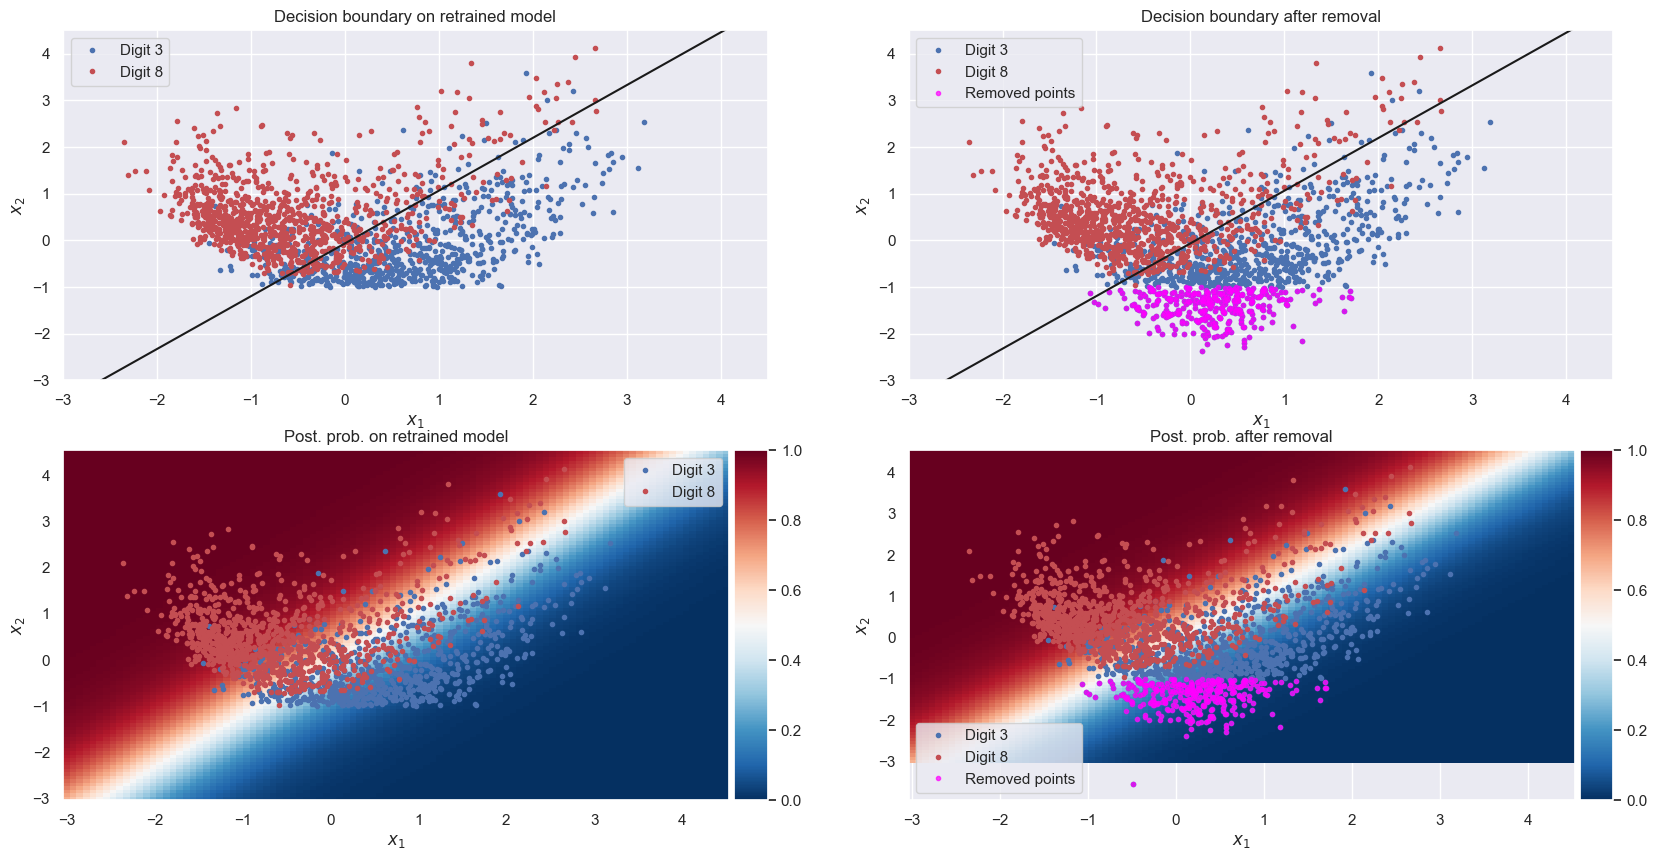

Accuracy = 0.857


In [10]:
regressor = LogisticRegression(learning_rate=0.001, num_iterations = 300, lam = lam, sigma = sigma)
regressor.fit(Z_train_remove[sum(mask):], y_train_remove[sum(mask):])
weights_retrained = regressor.w
decision_retrained = -(weights_retrained[0] + weights_retrained[1]*x_grid)/weights_retrained[2]
_, posterior1_eval_retrained = eval_density_grid(posterior1, weights_retrained)

accuracy_retrained = regressor.accuracy(Z_test, y_test)

fig, ax =  plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].plot(Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==0, 0], Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==0, 1], 'b.', label='Digit 3')
ax[0, 0].plot(Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==1, 0], Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==1, 1], 'r.', label='Digit 8')
ax[0, 0].plot(x_grid, decision_retrained, 'k-')
ax[0, 0].set(title='Decision boundary on retrained model', xlabel='$x_1$', ylabel='$x_2$')
ax[0, 0].set_xlim([-3.0, 4.5])
ax[0, 0].set_ylim([-3.0, 4.5])
ax[0, 0].legend()

ax[0, 1].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[0, 1].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
ax[0, 1].plot(Z_train[mask, 0], Z_train[mask, 1], '.', color =[1, 0, 1], alpha = 0.7, label = "Removed points")
ax[0, 1].set(title='Decision boundary after removal', xlabel='$x_1$', ylabel='$x_2$')
ax[0 ,1].plot(x_grid, decision_updated, 'k-')
ax[0, 1].set_xlim([-3.0, 4.5])
ax[0, 1].set_ylim([-3.0, 4.5])
ax[0, 1].legend()


im = ax[1, 0].pcolormesh(x_grid, x_grid, posterior1_eval_retrained, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
ax[1, 0].plot(Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==0, 0], Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==0, 1], 'b.', label='Digit 3')
ax[1, 0].plot(Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==1, 0], Z_train_remove[sum(mask):][y_train_remove[sum(mask):]==1, 1], 'r.', label='Digit 8')
ax[1, 0].set(title='Post. prob. on retrained model', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 0].legend()
add_colorbar(im, fig, ax[1, 0])

im = ax[1, 1].pcolormesh(x_grid, x_grid, posterior1_eval_updated, cmap=plt.cm.RdBu_r, shading='auto', vmin = 0.0, vmax = 1.0)
ax[1, 1].plot(Z_train[y_train==0, 0], Z_train[y_train==0, 1], 'b.', label='Digit 3')
ax[1, 1].plot(Z_train[y_train==1, 0], Z_train[y_train==1, 1], 'r.', label='Digit 8')
ax[1, 1].plot(Z_train[mask, 0], Z_train[mask, 1], '.', color =[1, 0, 1], alpha = 0.7, label = "Removed points")
ax[1, 1].set(title='Post. prob. after removal', xlabel='$x_1$', ylabel='$x_2$')
ax[1, 1].legend()
add_colorbar(im, fig, ax[1, 1])


plt.show()

print(f"Accuracy = {accuracy_retrained}")

In [11]:
print(weights)
print(weights_updated)
print(weights_retrained)

[-0.00931446 -1.84792535  1.80443466]
[ 0.10913494 -1.83297476  1.62435197]
[ 0.11024263 -1.83235866  1.62055338]


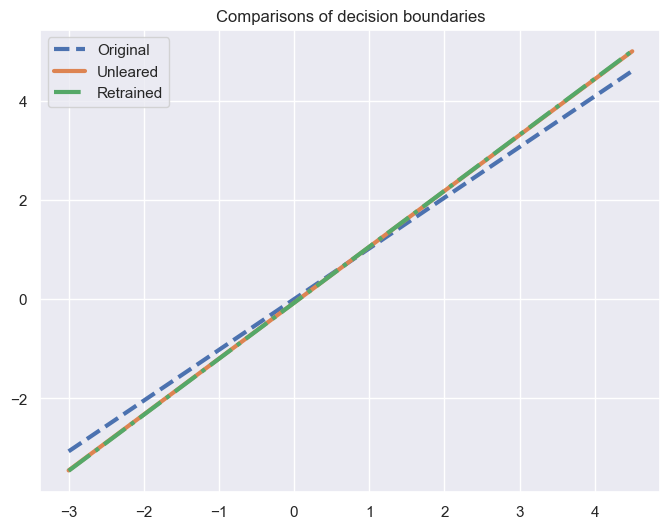

In [12]:
# %matplotlib qt 
%matplotlib inline 
plt.figure(figsize = (8, 6))
plt.plot(x_grid, -(weights[0] + weights[1] * x_grid) / weights[2], '--',  linewidth = 3, label = "Original")
plt.plot(x_grid, -(weights_updated[0] + weights_updated[1] * x_grid) / weights_updated[2], linewidth = 3, label = "Unleared")
plt.plot(x_grid, -(weights_retrained[0] + weights_retrained[1] * x_grid) / weights_retrained[2], '-.', linewidth = 3, label = "Retrained")
plt.legend()
plt.title("Comparisons of decision boundaries")
plt.show()